<a href="https://colab.research.google.com/github/prashantmalan/ALM/blob/main/ALM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

def generate_balance_sheet():
    # 1. Set up current date as reference
    current_date = datetime.now()

    # 2. Generate Assets (10000 entries)
    # Distribution: 80% long-term, 20% short-term
    n_assets = 10000
    n_long_term_assets = int(n_assets * 0.8)
    n_short_term_assets = n_assets - n_long_term_assets

    # Generate asset dates
    long_term_dates = [current_date + timedelta(days=np.random.randint(365, 3650))
                      for _ in range(n_long_term_assets)]
    short_term_dates = [current_date + timedelta(days=np.random.randint(1, 365))
                       for _ in range(n_short_term_assets)]

    # Generate asset amounts
    long_term_amounts = np.random.uniform(100000, 1000000, n_long_term_assets)
    short_term_amounts = np.random.uniform(10000, 100000, n_short_term_assets)

    # Create assets DataFrame
    assets_df = pd.DataFrame({
        'Type': ['Asset'] * n_assets,
        'Category': ['Long-term'] * n_long_term_assets + ['Short-term'] * n_short_term_assets,
        'Amount': np.concatenate([long_term_amounts, short_term_amounts]),
        'Maturity_Date': long_term_dates + short_term_dates
    })

    # 3. Generate Liabilities (100000 entries)
    # Distribution: 90% short-term, 10% long-term
    n_liabilities = 100000
    n_short_term_liab = int(n_liabilities * 0.9)
    n_long_term_liab = n_liabilities - n_short_term_liab

    # Generate liability dates
    short_term_liab_dates = [current_date + timedelta(days=np.random.randint(1, 365))
                            for _ in range(n_short_term_liab)]
    long_term_liab_dates = [current_date + timedelta(days=np.random.randint(365, 1825))
                           for _ in range(n_long_term_liab)]

    # Generate liability amounts
    short_term_liab_amounts = np.random.uniform(1000, 50000, n_short_term_liab)
    long_term_liab_amounts = np.random.uniform(50000, 200000, n_long_term_liab)

    # Create liabilities DataFrame
    liabilities_df = pd.DataFrame({
        'Type': ['Liability'] * n_liabilities,
        'Category': ['Short-term'] * n_short_term_liab + ['Long-term'] * n_long_term_liab,
        'Amount': np.concatenate([short_term_liab_amounts, long_term_liab_amounts]),
        'Maturity_Date': short_term_liab_dates + long_term_liab_dates
    })

    # 4. Combine assets and liabilities
    balance_sheet = pd.concat([assets_df, liabilities_df], ignore_index=True)

    # 5. Sort by maturity date
    balance_sheet = balance_sheet.sort_values('Maturity_Date')

    return balance_sheet

# Generate the balance sheet
balance_sheet = generate_balance_sheet()

# Print summary statistics
print("\nBalance Sheet Summary:")
print("-" * 50)
print("\nTotal Assets:", balance_sheet[balance_sheet['Type'] == 'Asset']['Amount'].sum())
print("Total Liabilities:", balance_sheet[balance_sheet['Type'] == 'Liability']['Amount'].sum())

print("\nAsset Distribution:")
print(balance_sheet[balance_sheet['Type'] == 'Asset']['Category'].value_counts())

print("\nLiability Distribution:")
print(balance_sheet[balance_sheet['Type'] == 'Liability']['Category'].value_counts())

# Save to CSV
balance_sheet.to_csv('balance_sheet.csv', index=False)
print("\nBalance sheet has been saved to 'balance_sheet.csv'")

# Display maturity analysis
print("\nMaturity Analysis:")
print("-" * 50)
print("\nEarliest Maturity:", balance_sheet['Maturity_Date'].min())
print("Latest Maturity:", balance_sheet['Maturity_Date'].max())


Balance Sheet Summary:
--------------------------------------------------

Total Assets: 4477079105.480137
Total Liabilities: 3546947199.183085

Asset Distribution:
Category
Long-term     8000
Short-term    2000
Name: count, dtype: int64

Liability Distribution:
Category
Short-term    90000
Long-term     10000
Name: count, dtype: int64

Balance sheet has been saved to 'balance_sheet.csv'

Maturity Analysis:
--------------------------------------------------

Earliest Maturity: 2025-03-24 15:37:30.797826
Latest Maturity: 2035-03-20 15:37:30.797826



Funding Analysis Summary:
--------------------------------------------------
Maximum Funding Need: 3,545,692,089.44
Maximum Surplus: 4,471,056,287.47
Days with Funding Need: 2334
Total Days Analyzed: 3649

Monthly Average Net Position:
Date
2025-03-31    4.447138e+09
2025-04-30    4.318367e+09
2025-05-31    4.117214e+09
2025-06-30    3.915763e+09
2025-07-31    3.709830e+09
                  ...     
2034-11-30   -3.356813e+09
2034-12-31   -3.405389e+09
2035-01-31   -3.450824e+09
2035-02-28   -3.498089e+09
2035-03-31   -3.533118e+09
Freq: ME, Name: Net_Position, Length: 121, dtype: float64


<ipython-input-13-03818dd0cdb5>:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = daily_df.set_index('Date').resample('M')['Net_Position'].mean()


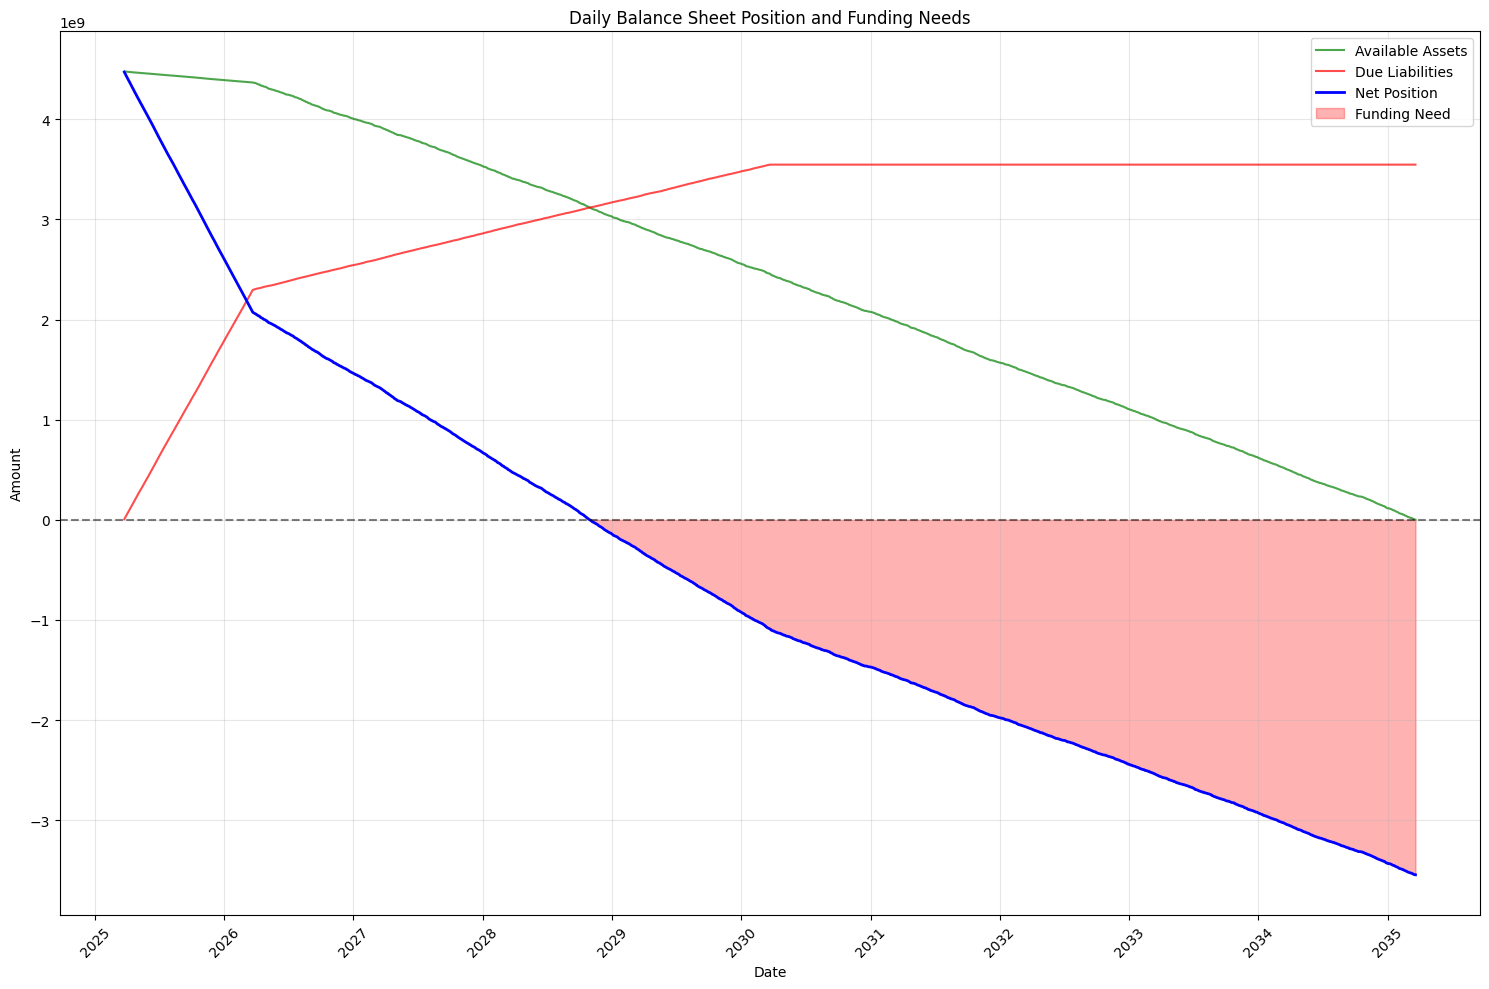

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_daily_funding():
    # Convert Maturity_Date to datetime if it's not already
    balance_sheet['Maturity_Date'] = pd.to_datetime(balance_sheet['Maturity_Date'])

    # Create date range from earliest to latest maturity
    date_range = pd.date_range(start=balance_sheet['Maturity_Date'].min(),
                             end=balance_sheet['Maturity_Date'].max(),
                             freq='D')

    # Calculate daily positions
    daily_positions = []
    for date in date_range:
        # Assets maturing on or after this date (available assets)
        available_assets = balance_sheet[
            (balance_sheet['Type'] == 'Asset') &
            (balance_sheet['Maturity_Date'] >= date)
        ]['Amount'].sum()

        # Liabilities due on or before this date (required funding)
        due_liabilities = balance_sheet[
            (balance_sheet['Type'] == 'Liability') &
            (balance_sheet['Maturity_Date'] <= date)
        ]['Amount'].sum()

        daily_positions.append({
            'Date': date,
            'Available_Assets': available_assets,
            'Due_Liabilities': due_liabilities,
            'Net_Position': available_assets - due_liabilities
        })

    # Convert to DataFrame
    daily_df = pd.DataFrame(daily_positions)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot assets and liabilities
    plt.plot(daily_df['Date'], daily_df['Available_Assets'],
             label='Available Assets', color='green', alpha=0.7)
    plt.plot(daily_df['Date'], daily_df['Due_Liabilities'],
             label='Due Liabilities', color='red', alpha=0.7)

    # Plot net position
    plt.plot(daily_df['Date'], daily_df['Net_Position'],
             label='Net Position', color='blue', linewidth=2)

    # Fill negative net position areas
    plt.fill_between(daily_df['Date'], daily_df['Net_Position'], 0,
                    where=(daily_df['Net_Position'] < 0),
                    color='red', alpha=0.3, label='Funding Need')

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Daily Balance Sheet Position and Funding Needs')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Tight layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot
    plt.savefig('funding_needs.png')

    # Calculate and print summary statistics
    print("\nFunding Analysis Summary:")
    print("-" * 50)
    print(f"Maximum Funding Need: {abs(min(daily_df['Net_Position'])):,.2f}")
    print(f"Maximum Surplus: {max(daily_df['Net_Position']):,.2f}")
    print(f"Days with Funding Need: {len(daily_df[daily_df['Net_Position'] < 0])}")
    print(f"Total Days Analyzed: {len(daily_df)}")

    # Create monthly average funding need
    monthly_avg = daily_df.set_index('Date').resample('M')['Net_Position'].mean()

    print("\nMonthly Average Net Position:")
    print(monthly_avg)

    return daily_df

# Run the analysis
daily_funding = analyze_daily_funding()

# Additional visualization: Heat map of funding needs by month and year
plt.figure(figsize=(12, 6))
daily_funding['Year'] = daily_funding['Date'].dt.year
daily_funding['Month'] = daily_funding['Date'].dt.month
funding_heat = daily_funding.pivot_table(
    values='Net_Position',
    index='Month',
    columns='Year',
    aggfunc='mean'
)

sns.heatmap(funding_heat, cmap='RdYlGn', center=0, annot=True, fmt='.0f')
plt.title('Monthly Average Funding Position')
plt.savefig('funding_heatmap.png')
plt.close()

# Export detailed funding report
daily_funding.to_csv('daily_funding_report.csv')

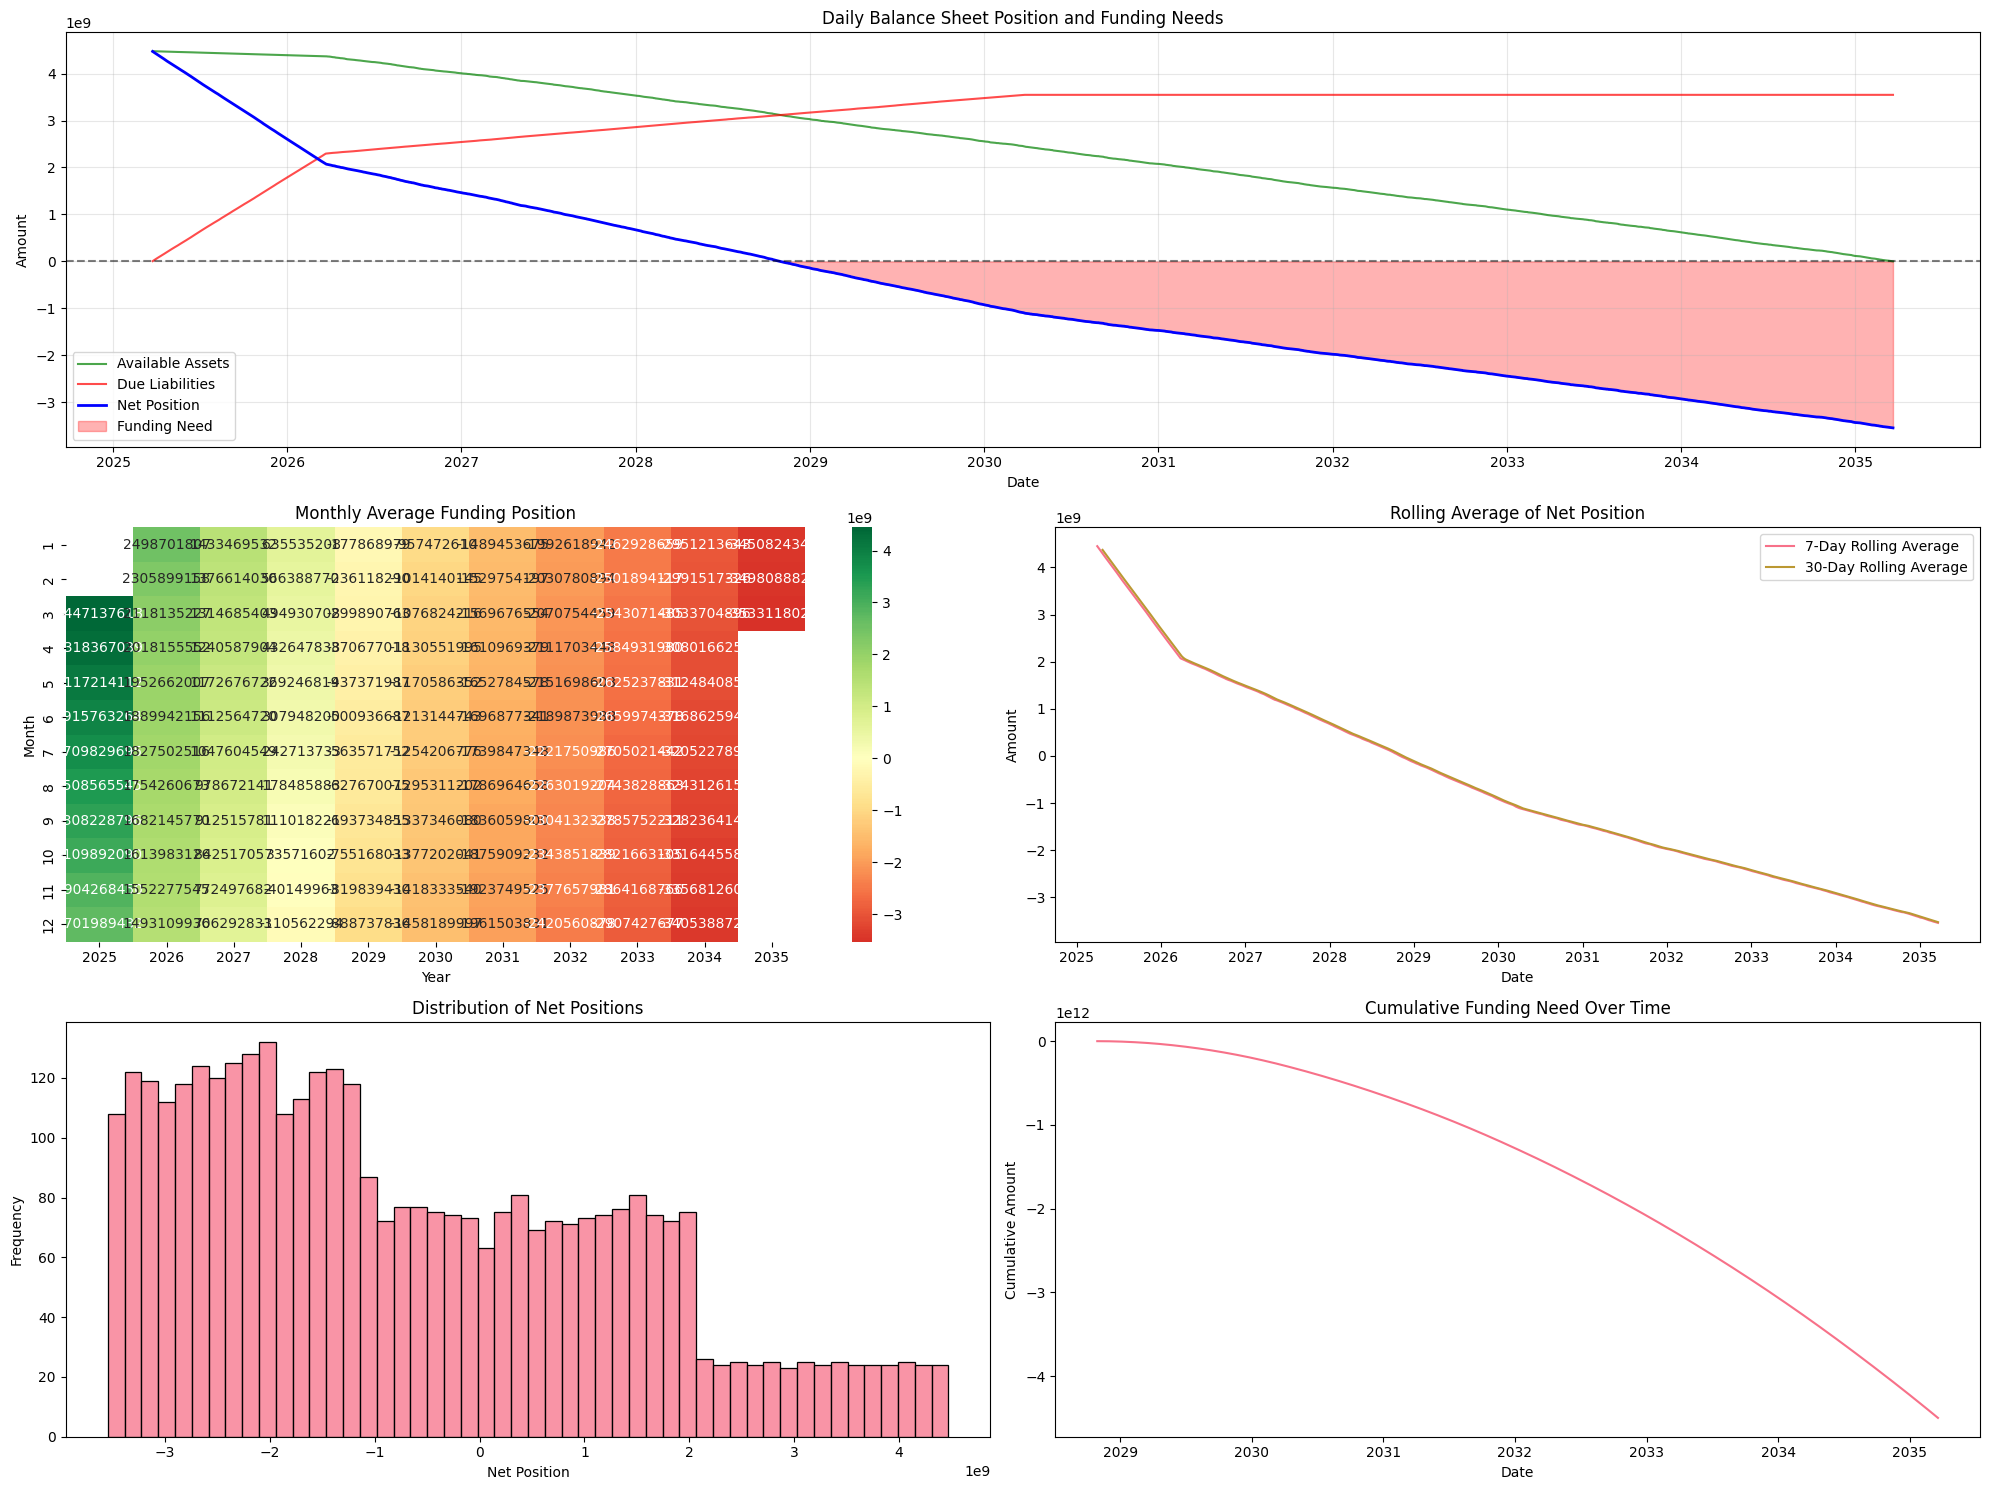


Detailed Funding Analysis:
--------------------------------------------------
Average Daily Funding Need: -1,928,184,023.77
Median Net Position: -1,091,122,163.37
Volatility (Std Dev) of Net Position: 2,016,575,005.07

Value at Risk (95%): 3,286,433,021.46
Value at Risk (99%): 3,492,530,332.41

Funding Gap Ratio (Short-term Assets/Liabilities): 0.05


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style for better visualization
#plt.style.use('seaborn')
sns.set_palette("husl")

def comprehensive_funding_analysis():
    # Calculate daily positions (using previous daily_positions calculation)
    balance_sheet['Maturity_Date'] = pd.to_datetime(balance_sheet['Maturity_Date'])
    date_range = pd.date_range(start=balance_sheet['Maturity_Date'].min(),
                             end=balance_sheet['Maturity_Date'].max(),
                             freq='D')

    daily_positions = []
    for date in date_range:
        available_assets = balance_sheet[
            (balance_sheet['Type'] == 'Asset') &
            (balance_sheet['Maturity_Date'] >= date)
        ]['Amount'].sum()

        due_liabilities = balance_sheet[
            (balance_sheet['Type'] == 'Liability') &
            (balance_sheet['Maturity_Date'] <= date)
        ]['Amount'].sum()

        daily_positions.append({
            'Date': date,
            'Available_Assets': available_assets,
            'Due_Liabilities': due_liabilities,
            'Net_Position': available_assets - due_liabilities
        })

    daily_df = pd.DataFrame(daily_positions)

    # Create a figure with multiple subplots using GridSpec
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 2, figure=fig)

    # 1. Main Funding Analysis Plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(daily_df['Date'], daily_df['Available_Assets'],
             label='Available Assets', color='green', alpha=0.7)
    ax1.plot(daily_df['Date'], daily_df['Due_Liabilities'],
             label='Due Liabilities', color='red', alpha=0.7)
    ax1.plot(daily_df['Date'], daily_df['Net_Position'],
             label='Net Position', color='blue', linewidth=2)
    ax1.fill_between(daily_df['Date'], daily_df['Net_Position'], 0,
                    where=(daily_df['Net_Position'] < 0),
                    color='red', alpha=0.3, label='Funding Need')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Daily Balance Sheet Position and Funding Needs')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Amount')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Monthly Heatmap
    ax2 = fig.add_subplot(gs[1, 0])
    daily_df['Year'] = daily_df['Date'].dt.year
    daily_df['Month'] = daily_df['Date'].dt.month
    funding_heat = daily_df.pivot_table(
        values='Net_Position',
        index='Month',
        columns='Year',
        aggfunc='mean'
    )
    sns.heatmap(funding_heat, cmap='RdYlGn', center=0, annot=True,
                fmt='.0f', ax=ax2)
    ax2.set_title('Monthly Average Funding Position')

    # 3. Rolling Average Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    daily_df['7D_Rolling_Avg'] = daily_df['Net_Position'].rolling(window=7).mean()
    daily_df['30D_Rolling_Avg'] = daily_df['Net_Position'].rolling(window=30).mean()
    ax3.plot(daily_df['Date'], daily_df['7D_Rolling_Avg'],
             label='7-Day Rolling Average')
    ax3.plot(daily_df['Date'], daily_df['30D_Rolling_Avg'],
             label='30-Day Rolling Average')
    ax3.set_title('Rolling Average of Net Position')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Amount')
    ax3.legend()

    # 4. Distribution of Net Positions
    ax4 = fig.add_subplot(gs[2, 0])
    sns.histplot(data=daily_df, x='Net_Position', bins=50, ax=ax4)
    ax4.set_title('Distribution of Net Positions')
    ax4.set_xlabel('Net Position')
    ax4.set_ylabel('Frequency')

    # 5. Cumulative Funding Need
    ax5 = fig.add_subplot(gs[2, 1])
    daily_df['Cumulative_Funding_Need'] = daily_df[daily_df['Net_Position'] < 0]['Net_Position'].cumsum()
    ax5.plot(daily_df['Date'], daily_df['Cumulative_Funding_Need'])
    ax5.set_title('Cumulative Funding Need Over Time')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Cumulative Amount')

    plt.tight_layout()
    plt.show()

    # Print additional analysis
    print("\nDetailed Funding Analysis:")
    print("-" * 50)
    print(f"Average Daily Funding Need: {daily_df[daily_df['Net_Position'] < 0]['Net_Position'].mean():,.2f}")
    print(f"Median Net Position: {daily_df['Net_Position'].median():,.2f}")
    print(f"Volatility (Std Dev) of Net Position: {daily_df['Net_Position'].std():,.2f}")

    # Calculate and print risk metrics
    var_95 = np.percentile(daily_df['Net_Position'], 5)
    var_99 = np.percentile(daily_df['Net_Position'], 1)
    print(f"\nValue at Risk (95%): {abs(var_95):,.2f}")
    print(f"Value at Risk (99%): {abs(var_99):,.2f}")

    # Calculate funding gap ratios
    total_short_term_assets = balance_sheet[
        (balance_sheet['Type'] == 'Asset') &
        (balance_sheet['Category'] == 'Short-term')
    ]['Amount'].sum()

    total_short_term_liab = balance_sheet[
        (balance_sheet['Type'] == 'Liability') &
        (balance_sheet['Category'] == 'Short-term')
    ]['Amount'].sum()

    funding_gap_ratio = total_short_term_assets / total_short_term_liab
    print(f"\nFunding Gap Ratio (Short-term Assets/Liabilities): {funding_gap_ratio:.2f}")

    return daily_df

# Run the comprehensive analysis
daily_funding_data = comprehensive_funding_analysis()

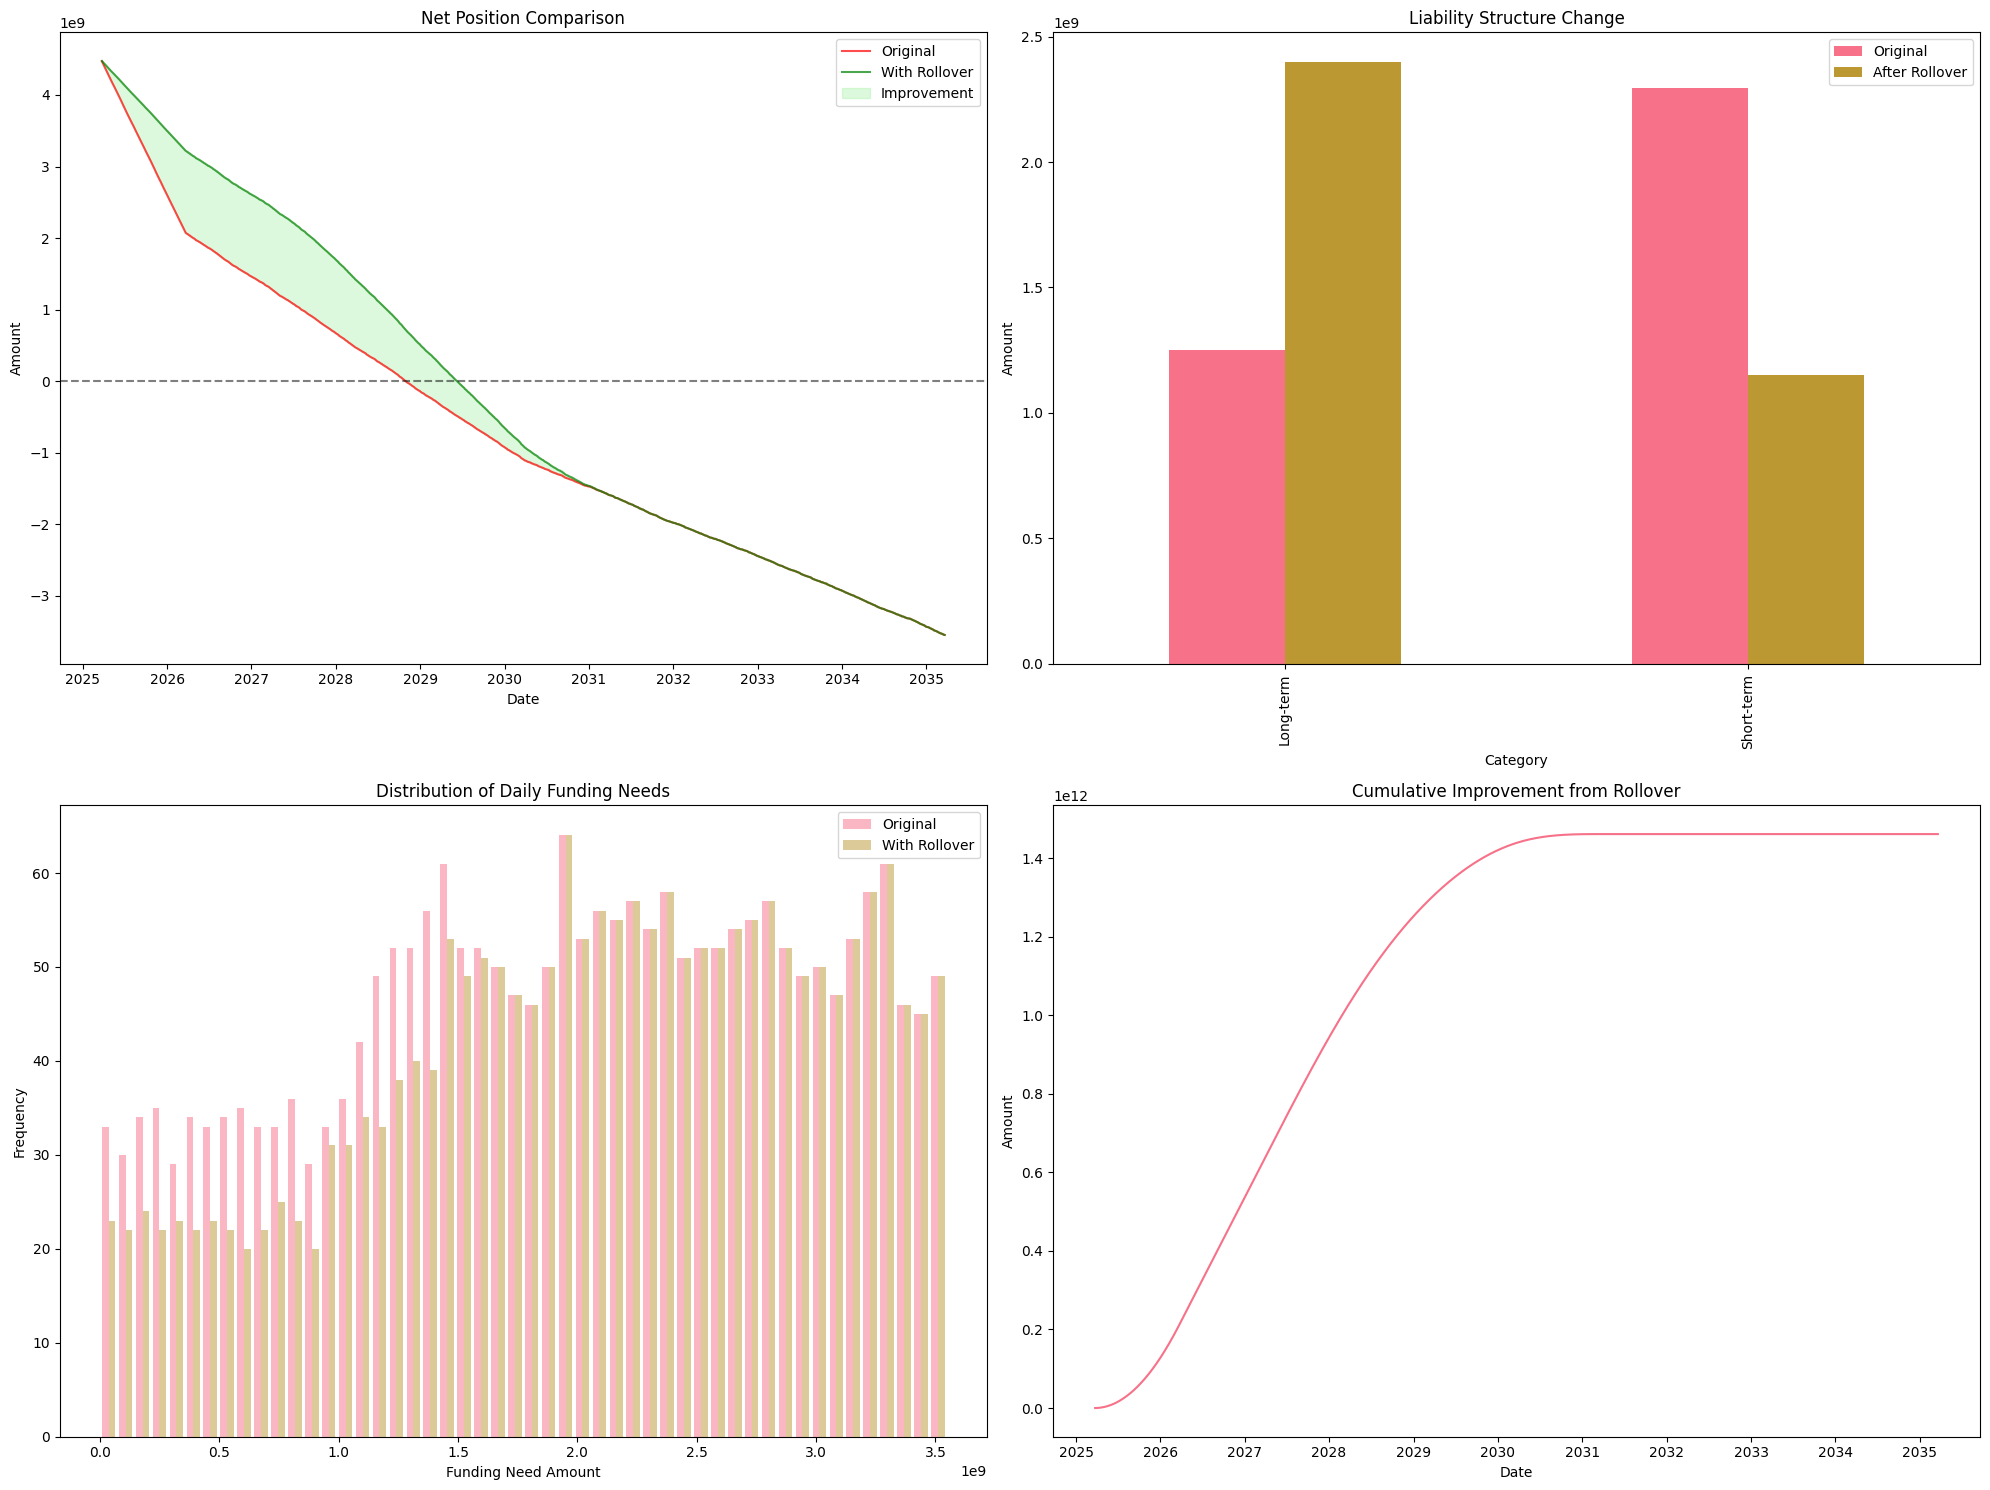


Rollover Analysis Summary:
--------------------------------------------------
Original maximum funding need: 3,545,692,089.44
Rollover maximum funding need: 3,545,692,089.44
Funding need reduction: 0.00

Liquidity Profile Improvement:
Days requiring funding (Original): 2334
Days requiring funding (After Rollover): 2111

Average Daily Funding Need:
Original: 1,928,184,023.77
After Rollover: 2,049,686,510.08

Liability Structure Change:
                Original  After Rollover
Category                                
Long-term   1.251308e+09    2.397367e+09
Short-term  2.295639e+09    1.149580e+09


In [20]:
def analyze_rollover_scenario(daily_df, rollover_percentage=0.50):
    # Create a copy of the original balance sheet
    rollover_balance_sheet = balance_sheet.copy()

    # Get the current date as reference
    reference_date = datetime.now()

    # Identify short-term liabilities
    short_term_liab = rollover_balance_sheet[
        (rollover_balance_sheet['Type'] == 'Liability') &
        (rollover_balance_sheet['Category'] == 'Short-term') &
        (rollover_balance_sheet['Maturity_Date'] <= reference_date + timedelta(days=365))
    ].copy()

    # Calculate number of liabilities to rollover
    n_rollover = int(len(short_term_liab) * rollover_percentage)

    # Randomly select liabilities for rollover
    rollover_indices = np.random.choice(short_term_liab.index, n_rollover, replace=False)

    # Extend maturity for selected liabilities (convert to long-term)
    rollover_balance_sheet.loc[rollover_indices, 'Category'] = 'Long-term'
    for idx in rollover_indices:
        current_maturity = rollover_balance_sheet.loc[idx, 'Maturity_Date']
        # Add 2-5 years to the maturity date
        extension_days = np.random.randint(730, 1825)  # 2-5 years in days
        rollover_balance_sheet.loc[idx, 'Maturity_Date'] = current_maturity + timedelta(days=extension_days)

    # Calculate new daily positions with rollover
    date_range = pd.date_range(start=daily_df['Date'].min(),
                             end=daily_df['Date'].max(),
                             freq='D')

    rollover_positions = []
    for date in date_range:
        # Available assets (not matured yet)
        available_assets = rollover_balance_sheet[
            (rollover_balance_sheet['Type'] == 'Asset') &
            (rollover_balance_sheet['Maturity_Date'] >= date)
        ]['Amount'].sum()

        # Due liabilities (matured by this date)
        due_liabilities = rollover_balance_sheet[
            (rollover_balance_sheet['Type'] == 'Liability') &
            (rollover_balance_sheet['Maturity_Date'] <= date)
        ]['Amount'].sum()

        rollover_positions.append({
            'Date': date,
            'Available_Assets': available_assets,
            'Due_Liabilities': due_liabilities,
            'Net_Position': available_assets - due_liabilities
        })

    rollover_df = pd.DataFrame(rollover_positions)

    # Create comparison plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

    # 1. Net Position Comparison
    ax1.plot(daily_df['Date'], daily_df['Net_Position'],
             label='Original', color='red', alpha=0.7)
    ax1.plot(rollover_df['Date'], rollover_df['Net_Position'],
             label='With Rollover', color='green', alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.fill_between(daily_df['Date'],
                     daily_df['Net_Position'],
                     rollover_df['Net_Position'],
                     where=(rollover_df['Net_Position'] > daily_df['Net_Position']),
                     color='lightgreen', alpha=0.3, label='Improvement')
    ax1.set_title('Net Position Comparison')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Amount')
    ax1.legend()

    # 2. Liability Structure Change
    liability_structure = pd.DataFrame({
        'Original': balance_sheet[balance_sheet['Type'] == 'Liability'].groupby('Category')['Amount'].sum(),
        'After Rollover': rollover_balance_sheet[rollover_balance_sheet['Type'] == 'Liability'].groupby('Category')['Amount'].sum()
    })
    liability_structure.plot(kind='bar', ax=ax2)
    ax2.set_title('Liability Structure Change')
    ax2.set_ylabel('Amount')

    # 3. Daily Funding Need Comparison
    daily_funding_orig = daily_df[daily_df['Net_Position'] < 0]['Net_Position'].abs()
    daily_funding_roll = rollover_df[rollover_df['Net_Position'] < 0]['Net_Position'].abs()

    ax3.hist([daily_funding_orig, daily_funding_roll],
             label=['Original', 'With Rollover'],
             bins=50, alpha=0.5)
    ax3.set_title('Distribution of Daily Funding Needs')
    ax3.set_xlabel('Funding Need Amount')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    # 4. Cumulative Improvement
    improvement = rollover_df['Net_Position'] - daily_df['Net_Position']
    cumulative_improvement = improvement.cumsum()
    ax4.plot(rollover_df['Date'], cumulative_improvement)
    ax4.set_title('Cumulative Improvement from Rollover')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Amount')

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nRollover Analysis Summary:")
    print("-" * 50)
    print(f"Original maximum funding need: {abs(daily_df['Net_Position'].min()):,.2f}")
    print(f"Rollover maximum funding need: {abs(rollover_df['Net_Position'].min()):,.2f}")
    print(f"Funding need reduction: {(abs(daily_df['Net_Position'].min()) - abs(rollover_df['Net_Position'].min())):,.2f}")

    print("\nLiquidity Profile Improvement:")
    print(f"Days requiring funding (Original): {len(daily_df[daily_df['Net_Position'] < 0])}")
    print(f"Days requiring funding (After Rollover): {len(rollover_df[rollover_df['Net_Position'] < 0])}")

    print("\nAverage Daily Funding Need:")
    print(f"Original: {abs(daily_df[daily_df['Net_Position'] < 0]['Net_Position'].mean()):,.2f}")
    print(f"After Rollover: {abs(rollover_df[rollover_df['Net_Position'] < 0]['Net_Position'].mean()):,.2f}")

    print("\nLiability Structure Change:")
    print(liability_structure)

    return rollover_df

# Run the corrected rollover analysis
rollover_analysis = analyze_rollover_scenario(daily_funding_data)